In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
import sqlite3
from datetime import datetime

#sns.set_style('whitegrid')

plt.style.use('ggplot')

%matplotlib inline

In [2]:
conn = sqlite3.connect(os.getcwd()+'\data\lending-club-loan-data\database.sqlite')
cursor = conn.cursor()
loans2 = pd.DataFrame(cursor.execute('SELECT * FROM LOAN').fetchall())
loans2.columns = np.array(cursor.execute('PRAGMA table_info(loan)').fetchall())[:,1]
conn.close()

In [3]:
# function to automate the above. no need for high level abstraction, since it's specific to this project and dataset
# i.e. keep it simple 

def select(query):
    conn = sqlite3.connect(os.getcwd()+'\data\lending-club-loan-data\database.sqlite')
    cursor = conn.cursor()
    temp_df = pd.DataFrame(cursor.execute(query).fetchall())
    temp_df.columns = list(map(lambda x: x[0], cursor.description))
    conn.close()
    
    return temp_df.copy()


In [4]:
loans3 = select('SELECT * FROM LOAN')

In [5]:
test = select('SELECT member_id, funded_amnt, term, int_rate FROM LOAN')

In [6]:
test.head()

,member_id,funded_amnt,term,int_rate
0,1296599.0,5000.0,36 months,10.65%
1,1314167.0,2500.0,60 months,15.27%
2,1313524.0,2400.0,36 months,15.96%
3,1277178.0,10000.0,36 months,13.49%
4,1311748.0,3000.0,60 months,12.69%


In [7]:
loans2.describe()

,index,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
count,887383.000000,8.873820e+05,887382.000000,887382.000000,887382.000000,887382.000000,8.873780e+05,887382.00000,887353.000000,887353.000000,...,21372.000000,18617.000000,21372.000000,21372.000000,21372.000000,21372.000000,8.171060e+05,21372.000000,21372.000000,21372.000000
mean,152155.671062,3.500184e+07,14755.280082,14741.893147,14702.480039,436.717647,7.502761e+04,18.15702,0.314445,0.694622,...,36552.811389,71.535317,1.389060,2.975482,5887.979740,60.831939,3.206868e+04,0.943945,1.537058,1.977307
std,111089.623731,2.411336e+07,8435.456408,8429.898507,8442.107612,244.186619,6.469823e+04,17.19060,0.862247,0.998447,...,43103.833619,23.022862,1.520129,2.631886,5284.701239,20.013254,3.749833e+04,1.446872,2.723339,2.874067
min,0.000000,7.047300e+04,500.000000,500.000000,0.000000,15.670000,0.000000e+00,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-4.000000
25%,59769.500000,1.087713e+07,8000.000000,8000.000000,8000.000000,260.710000,4.500000e+04,11.91000,0.000000,0.000000,...,10251.500000,58.600000,0.000000,1.000000,2411.000000,47.700000,1.390000e+04,0.000000,0.000000,0.000000
50%,133718.000000,3.709528e+07,13000.000000,13000.000000,13000.000000,382.550000,6.500000e+04,17.65000,0.000000,0.000000,...,24684.500000,74.900000,1.000000,2.000000,4483.000000,61.900000,2.370000e+04,0.000000,0.000000,2.000000
75%,217438.500000,5.847135e+07,20000.000000,20000.000000,20000.000000,572.600000,9.000000e+04,23.95000,0.000000,1.000000,...,47858.000000,87.600000,2.000000,4.000000,7771.500000,75.200000,3.980000e+04,1.000000,2.000000,3.000000
max,421094.000000,7.354484e+07,35000.000000,35000.000000,35000.000000,1445.460000,9.500000e+06,9999.00000,39.000000,33.000000,...,878459.000000,223.300000,22.000000,43.000000,127305.000000,151.400000,9.999999e+06,17.000000,35.000000,32.000000


In [8]:
loans2.last_pymnt_d.head()

0    Jan-2015
1    Apr-2013
2    Jun-2014
3    Jan-2015
4    Jan-2016
Name: last_pymnt_d, dtype: object

In [9]:
# loan_status will be the target variable. 10 possible classes
# remove the "does not meet the credit policy" targets. adds complexity without interpretability 

for status in np.unique(loans2['loan_status'].astype(str)):
    print(status)
    print(str(len(loans2[loans2['loan_status']==str(status)])))

Charged Off
45248
Current
601781
Default
1219
Does not meet the credit policy. Status:Charged Off
761
Does not meet the credit policy. Status:Fully Paid
1988
Fully Paid
207724
In Grace Period
6253
Issued
8460
Late (16-30 days)
2357
Late (31-120 days)
11591
None
0


### binary targets labels (loans completed)

In [10]:
binary_output = ['Fully_Paid','Charged_Off']

### multi class target labels (loans in progress)

In [11]:
# there is somewhat of an ordering here. 

multi_output = ['Current','Late (16-30 days)','Late (31-120 days)','Default']

### experimental exploration (loans about to begin payment)

In [12]:
exploration = ['Issued','In Grace Period']

In [13]:
# drop columns which have > 400k NaN values?
# may be able to figure out to fill values for next_pymnt_d (250k missing values)

loans2.isnull().sum().sort_values(ascending=False)[:30]

dti_joint                      886874
verification_status_joint      886872
annual_inc_joint               886872
il_util                        868766
mths_since_rcnt_il             866573
all_util                       866011
max_bal_bc                     866011
open_rv_24m                    866011
open_rv_12m                    866011
total_cu_tl                    866011
total_bal_il                   866011
open_il_24m                    866011
open_il_12m                    866011
open_il_6m                     866011
open_acc_6m                    866011
inq_fi                         866011
inq_last_12m                   866011
desc                           761354
mths_since_last_record         750330
mths_since_last_major_derog    665679
mths_since_last_delinq         454314
next_pymnt_d                   252973
tot_cur_bal                     70277
total_rev_hi_lim                70277
tot_coll_amt                    70277
emp_title                       51458
last_pymnt_d

In [14]:
loans2.columns

Index(['index', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url',
       'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       'verification_sta

In [15]:
# note: some of the features below may switch between subsets after processing. e.g. many of date time will become numerical

In [16]:
# do all specification for subets of data within SQL. use these lists to construct the SQL queries as strings 

## columns which describe borrower:

In [17]:
borrower_desc = ['dti','annual_inc','emp_length','delinq_2yrs','inq_last_6mths','mths_since_last_delinq','earliest_cr_line',
                'home_ownership','addr_state','open_acc','pub_rec','revol_bal','revol_util','total_acc',
                'collections_12_mths_ex_med','mths_since_last_major_derog','acc_now_delinq']

## columns which describe loan structure:

In [18]:
loan_desc = ['funded_amnt','loan_amnt','int_rate','installment','sub_grade','out_prncp','total_pymnt','total_rec_prncp',
            'total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_amnt','verification_status',
            'pymnt_plan','next_pymnt_d','last_credit_pull_d','last_pymnt_d']

### categorical

In [19]:
categories = ['sub_grade','home_ownership_verification_status','verification_status','pymnt_plan','purpose','addr_state',
             'initial_list_status','policy_code','application_type']

### date-time

In [20]:
datetime = ['term','issue_d','earliest_cr_line','next_pymnt_d','last_credit_pull_d','last_pymnt_d']

### numerical

In [21]:
numerical = ['dti','annual_inc','funded_amnt','loan_amnt','funded_amnt_inv','int_rate','installment','sub_grade','emp_length',
            'delinq_2yrs','inq_last_6mths','mths_since_last_delinq','open_acc','pub_rec','revol_bal','revol_util','total_acc',
            'out_prncp','total_pymnt','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries',
            'collection_recovery_fee','last_pymnt_amnt','collections_12_mths_ex_med','mths_since_last_major_derog',
            'acc_now_delinq','tot_coll_amt','total_cur_bal']

In [22]:
# strange bug not allowing the whole column to be changed, b/c of a single NaN value that wont be removed..

loans2['term'] = loans2[loans2['term']!='nan']['term']
loans2['term'] = loans2['term'].dropna()

import re 

f = lambda x : int(re.findall(r"\D(\d{2})\D",x)[0])

loans2['term'].head().apply(f)

0    36
1    60
2    36
3    36
4    60
Name: term, dtype: int64

In [23]:
np.unique(loans2['term'].astype(str).values)

array([' 36 months', ' 60 months', 'nan'], dtype=object)

In [24]:
# dropna not dropping a single NaN...weird bug

loans2['term'][39783:39789]

39783     36 months
39784     36 months
39785     36 months
39786           NaN
39787     60 months
39788     60 months
Name: term, dtype: object

In [25]:
# example "total loan repayment"
# it seems the last installment is probably partial, no need for this feature engineering..just use total pymnt

loans2['installment'].head()*loans2['term'].head().apply(f)

0     5863.32
1     3589.80
2     3035.88
3    12215.16
4     4067.40
dtype: float64

In [26]:
# example "total net % return" (over entire life of loan)

((loans2['installment'].head()*loans2['term'].head().apply(f))/loans2['funded_amnt'].head() - 1)*100

0    17.2664
1    43.5920
2    26.4950
3    22.1516
4    35.5800
dtype: float64

In [27]:
np.unique(loans2['loan_status'].dropna())

array(['Charged Off', 'Current', 'Default',
       'Does not meet the credit policy. Status:Charged Off',
       'Does not meet the credit policy. Status:Fully Paid', 'Fully Paid',
       'In Grace Period', 'Issued', 'Late (16-30 days)',
       'Late (31-120 days)'], dtype=object)

## FULLY PAID

In [28]:
# specify this in SQL in the actual project

fully_paid = loans2[loans2['loan_status']=='Fully Paid']

In [29]:
fully_paid[['funded_amnt','int_rate','term','installment','last_pymnt_amnt',
            'total_rec_prncp','total_rec_late_fee','total_rec_int','total_pymnt']].head()

,funded_amnt,int_rate,term,installment,last_pymnt_amnt,total_rec_prncp,total_rec_late_fee,total_rec_int,total_pymnt
0,5000.0,10.65%,36 months,162.87,171.62,5000.0,0.00,861.07,5861.071414
2,2400.0,15.96%,36 months,84.33,649.91,2400.0,0.00,603.65,3003.653644
3,10000.0,13.49%,36 months,339.31,357.48,10000.0,16.97,2209.33,12226.302212
5,5000.0,7.90%,36 months,156.46,161.03,5000.0,0.00,631.38,5631.377753
7,3000.0,18.64%,36 months,109.43,111.34,3000.0,0.00,938.14,3938.144334


In [30]:
# net return over lifetime of loan

(fully_paid['total_pymnt']/fully_paid['funded_amnt']).head()

0    1.172214
2    1.251522
3    1.222630
5    1.126276
7    1.312715
dtype: float64

## CHARGED OFF

In [31]:
charged_off = loans2[loans2['loan_status']=='Charged Off']

In [32]:
charged_off[['funded_amnt','recoveries']].head()

,funded_amnt,recoveries
1,2500.0,117.08
8,5600.0,189.06
9,5375.0,269.29
12,9000.0,444.30
14,10000.0,645.10


## example code to write the pre-processed (clean) data to a table in the SQL database

In [33]:
# conn = sqlite3.connect(os.getcwd()+'\data\lending-club-loan-data\database2.sqlite')
# cursor = conn.cursor()
# example_df.to_sql('example_table_name',conn)
# tables = pd.DataFrame(cursor.execute('SELECT * FROM SQLITE_MASTER').fetchall())
# conn.close()

---
## Exploratory Analysis

In [34]:
conn = sqlite3.connect(os.getcwd()+'\data\lending-club-loan-data\database2.sqlite')
cursor = conn.cursor()
loansP = pd.DataFrame(cursor.execute('SELECT * FROM LOAN_FINAL').fetchall())
loansP.columns = np.array(cursor.execute('PRAGMA table_info(loan_final)').fetchall())[:,1]
conn.close()

In [35]:
charged_off1 = loansP[loansP.loan_status=='Charged Off']
fully_paid1 = loansP[loansP.loan_status=='Fully Paid']

In [36]:
numerical = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term',\
             'int_rate', 'installment', 'grade', 'emp_length', 'annual_inc', \
             'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', \
             'policy_code', 'acc_now_delinq']

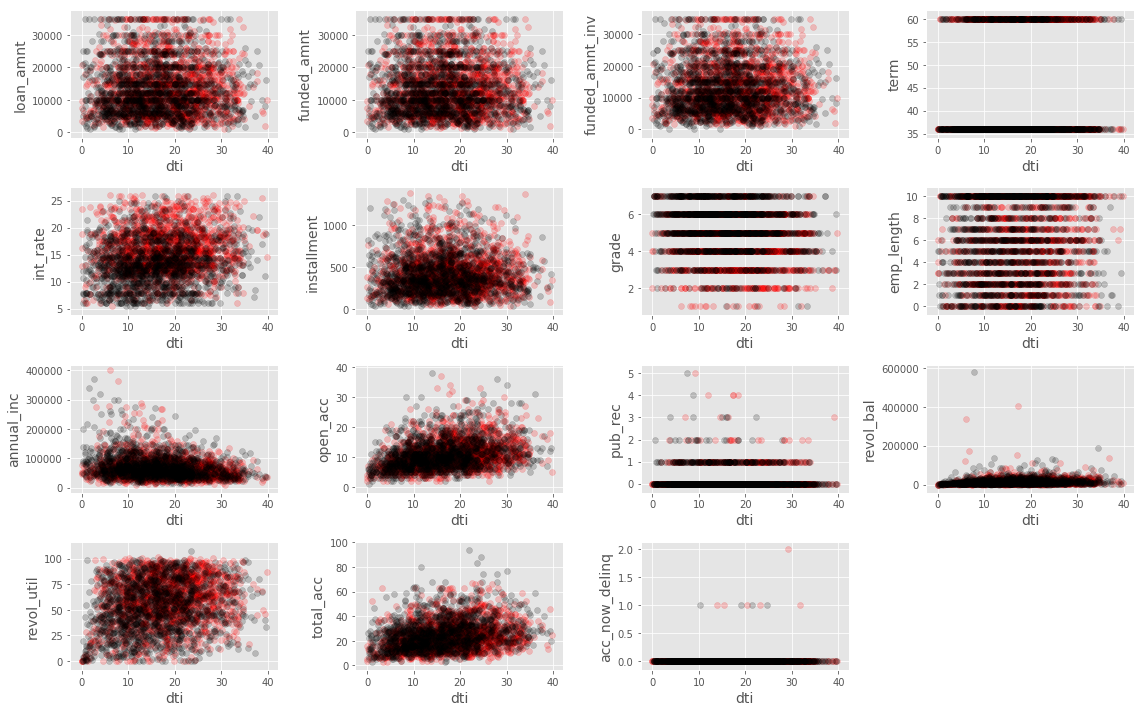

In [51]:
fig = plt.figure(figsize=(16,10))


d = 0 
k = 0
for i in range(len(numerical)):
    features = ['dti',numerical[k]]
    if features[1] == 'policy_code':
        k+=1
        d-=1
        continue
    if features[1] == 'dti':
        k += 1
        d -= 1
        continue
    
    charged_off_sample = charged_off1[features].sample(1500,random_state=2)
    fully_paid_sample = fully_paid1[features].sample(1500,random_state=2)
    
    ax = fig.add_subplot(4,4,i+1+d)
    ax.scatter(charged_off_sample[features[0]],charged_off_sample[features[1]],facecolor='r',alpha=0.2)
    ax.scatter(fully_paid_sample[features[0]],fully_paid_sample[features[1]],facecolor='k',alpha=0.2)
    ax.set_ylabel(features[1],fontsize=14)
    ax.set_xlabel(features[0],fontsize=14)
    k += 1

plt.tight_layout()

#plt.savefig('./report/feature-plots1.jpg')

In [38]:
numerical

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'emp_length',
 'annual_inc',
 'dti',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'policy_code',
 'acc_now_delinq']

C:\Users\Pablo\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\Users\Pablo\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


ValueError: num must be 1 <= num <= 12, not 13

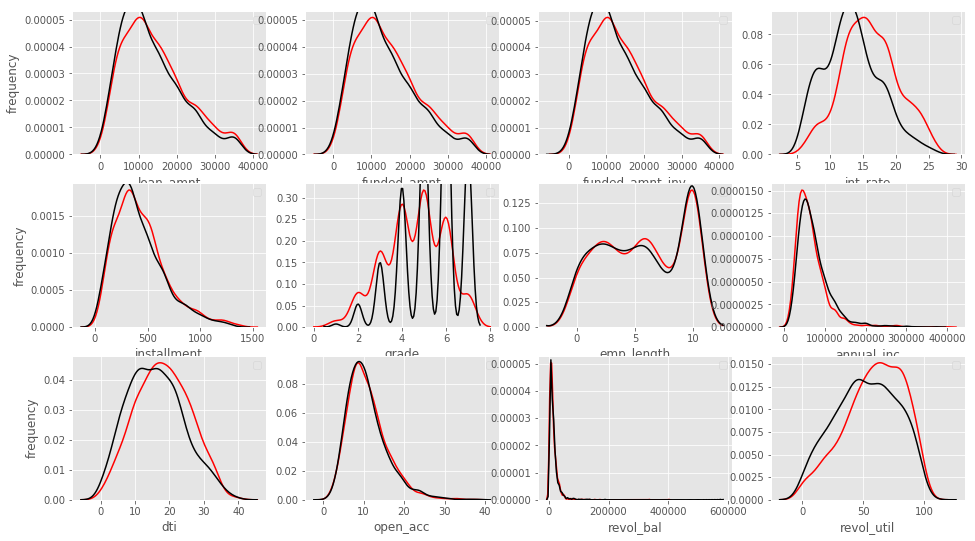

In [39]:
fig = plt.figure(figsize=(16,9))

charged_off_sample = charged_off1.sample(1500,random_state=2)
fully_paid_sample = fully_paid1.sample(1500,random_state=2)

k = 1 
d = 0

for feature in numerical:
    
    if feature in ['term','pub_rec','acc_now_delinq','policy_code']:
        k += 1
        d += 1
        continue
    
    ax = fig.add_subplot(3,4,k-d)
    sns.kdeplot(charged_off_sample[feature],color='r')
    sns.kdeplot(fully_paid_sample[feature],color='k')
    ax.set_xlabel(feature)
    ax.legend([])
    
    if (k-d) in [1,5,9]:
        ax.set_ylabel('frequency')
    
    k += 1

plt.tight_layout()

#plt.savefig('./report/kde.jpg')

In [ ]:
loansP = loansP[(loansP.loan_status=='Fully Paid')|(loansP.loan_status=='Charged Off')]

In [ ]:
outputmap = {'Fully Paid':1,'Charged Off':0}

loansP.loan_status = loansP.loan_status.apply(lambda x: outputmap[x])

In [ ]:
loansP[numerical+['loan_status']].corr()['loan_status'].sort_values(ascending=False)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# this column has some missing values that will be dealt with later..we remove it for now to do simple analysis

numerical.remove('revol_util')

In [ ]:
co = np.array(pd.DataFrame(PCA(n_components=2).fit_transform(charged_off1[numerical])).sample(10000))
fp = np.array(pd.DataFrame(PCA(n_components=2).fit_transform(fully_paid1[numerical])).sample(10000))

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,6))

ax1.scatter(co[:,0],co[:,1],color='r',alpha=0.2)
ax1.set_xlim([-100000,300000])
ax1.set_ylim([-50000,100000])
ax1.set_title('Defaulted',fontsize=18)
ax1.set_ylabel('PCA\nComponent 2',rotation=0,labelpad=55,fontsize=16)
ax1.set_xlabel('PCA Component 1',fontsize=16)

ax2.scatter(fp[:,0],fp[:,1],color='k',alpha=0.2)
ax2.set_xlim([-100000,300000])
ax2.set_ylim([-50000,100000])
ax2.set_title('Fully Paid',fontsize=18)
ax2.set_xlabel('PCA Component 1',fontsize=16)

ax3.scatter(co[:,0],co[:,1],color='r',alpha=0.2)
ax3.scatter(fp[:,0],fp[:,1],color='k',alpha=0.2)
ax3.set_xlim([-100000,300000])
ax3.set_ylim([-50000,100000])
ax3.set_title('Class Overlap',fontsize=18)
ax3.set_xlabel('PCA Component 1',fontsize=16)

plt.tight_layout()

#plt.savefig('./report/PCA-overlap.jpg')